In [8]:
import pprint
import os
from rdflib import Namespace
from cmmn3 import parseModel, convertModel, convertLog, reasonAll, showCase, aggregateErrors, showErrors

n3Path = "cmmn3/n3/"
xmlNs = {"cmmn": "http://www.omg.org/spec/CMMN/20151109/MODEL"}
modelNs = Namespace("http://ontario.org/qbp/cap#")

xmlPath = "/Users/wvw/Dropbox/research/projects/Montfort PM/cmmn/cap-all.cmmn"
modelPath = "ttl/cap/model.ttl"
csvFolder = "/Users/wvw/git/pm/mft/data/subsets/"
evtPath = os.path.join(csvFolder, "cap-events-labreq_map.csv")
statePath = os.path.join(csvFolder, "cap-status-admit.csv")
cdataPath = os.path.join(csvFolder, "cap-clinical_data.csv")
obsPath = "ttl/cap/obs/obs_all.ttl"
imgPath = "js/diagram.png"

# Convert TTL

## Model

In [32]:
itemObjs = parseModel(xmlPath, xmlNs)
# pprint.pprint(itemObjs)
convertModel(itemObjs, modelNs, modelPath)

## Log

### Align clinical state with events

In [57]:
import pandas as pd

In [58]:
df = pd.read_csv(cdataPath, index_col=0)
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

In [59]:
df['time:until'] = df.groupby([ 'case:concept:name', 'concept:name' ])['time:timestamp'].shift(-1)
dtimes = df.rename({"time:timestamp": "time:from"}, axis=1)

In [60]:
dtimes[dtimes['case:concept:name']==88]

,case:concept:name,patient,concept:name,value,time:from,time:until
0,88,ER000042,BP diastolic,58.0,2022-02-21 15:01:00,2022-02-21 20:25:00
1,88,ER000042,BP systolic,123.0,2022-02-21 15:01:00,2022-02-21 20:25:00
2,88,ER000042,Body Temperature,37.2,2022-02-21 15:01:00,2022-02-21 20:25:00
3,88,ER000042,Heart rate,84.0,2022-02-21 15:01:00,2022-02-21 20:25:00
4,88,ER000042,Respiratory rate,20.0,2022-02-21 15:01:00,2022-02-21 20:25:00
5,88,ER000042,BP diastolic,51.0,2022-02-21 20:25:00,2022-02-21 22:00:00
6,88,ER000042,BP systolic,106.0,2022-02-21 20:25:00,2022-02-21 22:00:00
7,88,ER000042,Body Temperature,37.1,2022-02-21 20:25:00,2022-02-21 21:15:00
8,88,ER000042,Heart rate,84.0,2022-02-21 20:25:00,2022-02-21 22:00:00
9,88,ER000042,Respiratory rate,22.0,2022-02-21 20:25:00,2022-02-21 22:00:00


In [74]:
df2 = pd.read_csv(evtPath, index_col=0)
for case, g in df2.groupby('case:concept:name'):
    states = []
    idx_state = {}
    align = [] # aligns each event with state ID

    # print(case)
    for index, row in g.iterrows():
        # print(index, row['case:concept:name'], row['time:timestamp'])
        found = dtimes[
            (dtimes['case:concept:name'] == row['case:concept:name']) & 
            (row['time:timestamp'] >= dtimes['time:from']) & ( (row['time:timestamp'] <= dtimes['time:until']) | ( dtimes['time:until'].isna() ) )
        ]

        # state ID = index of rows
        idx = tuple(found.index)
        # state already encountered; re-use ID
        if idx in idx_state:
            state_nr = idx_state[idx]
        else:
            # add new state & get ID
            state_nr = len(states)
            states.append(found)
            idx_state[idx] = state_nr
        
        # add state ID for event
        align.append(state_nr)

    if case == 88:
        break

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_93424/3556617007.py:1: DtypeWarning: Columns (34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(evtPath, index_col=0)


In [ ]:
convertLog(evtPath, modelNs, destPath=obsPath)

# Check compliance

## Reason

In [66]:
out = reasonAll(modelPath, obsPath, n3Path, printerr=False)
errors, finals = out
print("errors:", errors.columns)
print("finals:", finals.columns)

count: 0
count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 70
count: 80
count: 90
count: 100
errors: Index(['case', 'item', 'error', 'type'], dtype='object')
finals: Index(['case', 'item', 'type'], dtype='object')


## Show

In [5]:
itemObjs = parseModel(xmlPath, xmlNs)

In [6]:
showCase(out, '100057', itemObjs, xmlPath, imgPath)

'ERROR : could not import CMMN 2.0 diagram JSHandle@error\n'

In [67]:
agg_errors = aggregateErrors(out)
agg_errors

,item,item_cnt,item_perc,error,item_error_cnt,item_error_perc
0,Blood cultures,100,100.0,mandatoryNotDone,100,100.0
1,antibiotics,100,100.0,mandatoryNotDone,100,100.0
2,oxygen saturation,100,100.0,inactiveToCompleted,7,7.0
3,oxygen saturation,100,100.0,mandatoryNotDone,93,93.0
4,"routine bloodwork: CBC, electrolytes, renal fu...",129,129.0,inactiveToCompleted,29,29.0
5,"routine bloodwork: CBC, electrolytes, renal fu...",129,129.0,mandatoryNotDone,71,71.0
6,"routine bloodwork: CBC, electrolytes, renal fu...",129,129.0,nonRepetitiveMultipleCompleted,29,29.0
7,urine antigen testing,100,100.0,mandatoryNotDone,100,100.0


In [63]:
errors[errors['item']=='oxygen saturation']

,case,item,error,type
3,13,oxygen saturation,mandatoryNotDone,Inactive
8,88,oxygen saturation,inactiveToCompleted,Completed
39,464,oxygen saturation,mandatoryNotDone,Inactive
44,499,oxygen saturation,mandatoryNotDone,Inactive
97,1025,oxygen saturation,mandatoryNotDone,Inactive
...,...,...,...,...
1220,5947,oxygen saturation,mandatoryNotDone,Inactive
1225,6140,oxygen saturation,mandatoryNotDone,Inactive
1251,6141,oxygen saturation,mandatoryNotDone,Inactive
1256,6143,oxygen saturation,mandatoryNotDone,Inactive


In [ ]:
# TODO inactiveToCompleted: show on outer stage

showErrors(agg_errors, itemObjs, xmlPath, imgPath)

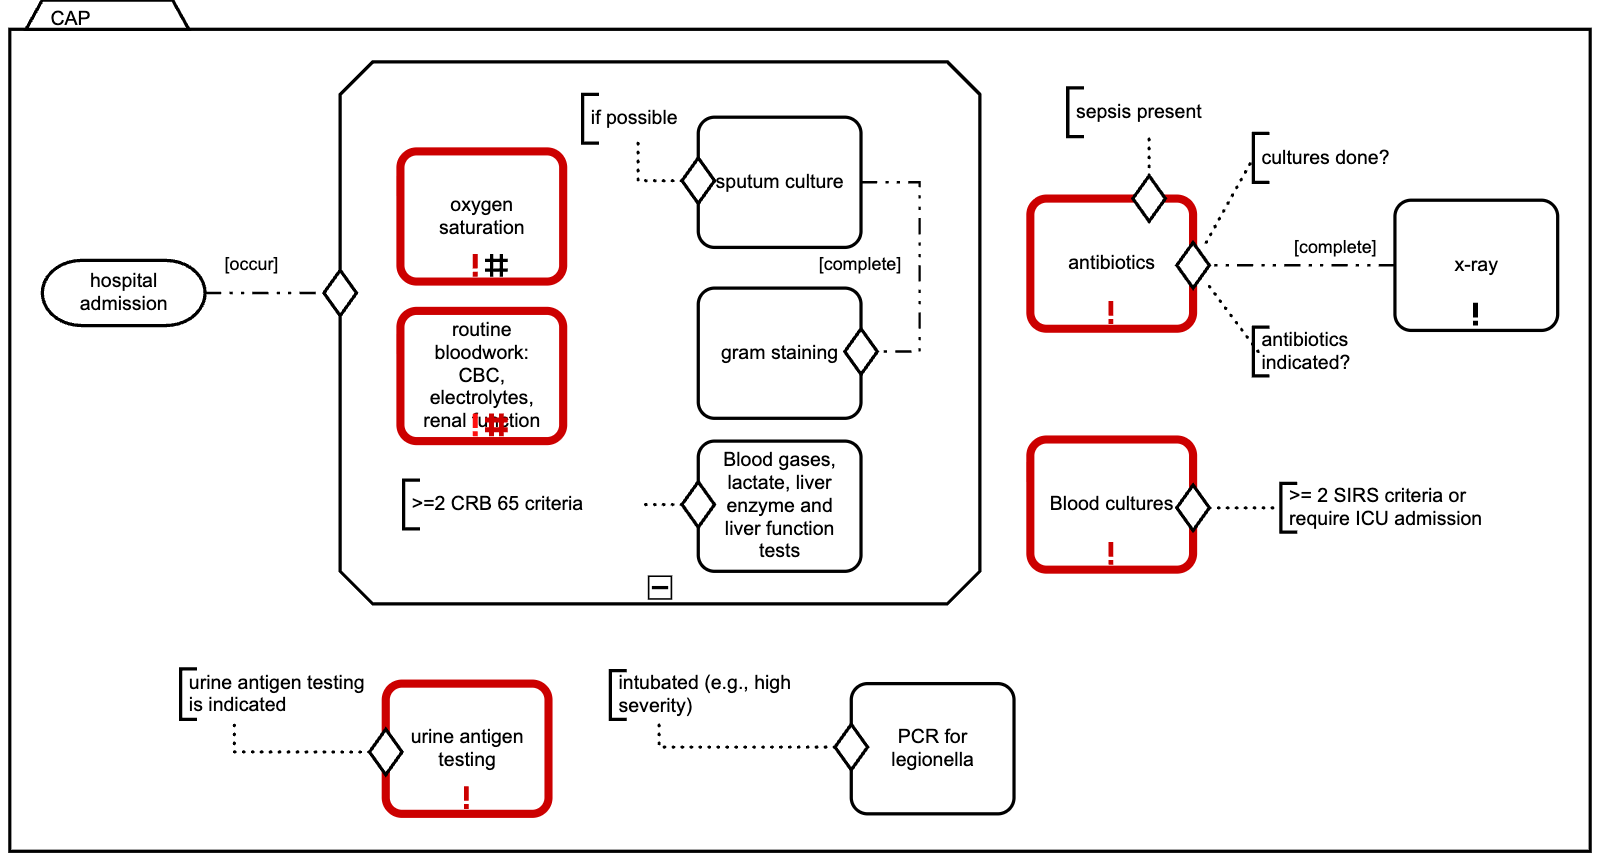

In [126]:
from IPython.display import Image, display

display(Image(filename=imgPath))